In [2]:
import mne, os
import pickle
import numpy as np 
import pandas as pd
import time

path = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Scripts/Processed_Data/'

# Specify the custom filename from which you want to load the pickle file
file_name = path + 'S13datastillNoCatch-epo.fif'
file_name2 = path + 'S13datamovieNoCatch-epo.fif'

# Use the pickle.load() method to load the 'Epochs' object from the custom filename

S13_stacked = mne.read_epochs(file_name, preload=True)

S13_stackedMovie = mne.read_epochs(file_name2, preload=True)






Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Scripts/Processed_Data/S13datastillNoCatch-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Scripts/Processed_Data/S13datamovieNoCatch-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    3200.00 ms
        0 CTF compensation matrices available
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated


In [3]:
epochs_stacked = S13_stacked
epochs_stackedMovie = S13_stackedMovie

In [10]:
print(epochs_stacked[1])

<EpochsFIF |  1 events (all good), -0.2 – 0.6 s, baseline -0.2 – 0 s, ~2.2 MB, data loaded,
 'S01/Watch_Still/45_Left': 1>


In [6]:
# add metadata
block_type = [k.split('/')[1] for k in epochs_stacked.event_id.keys()]
condition = [k.split('/')[2] for k in epochs_stacked.event_id.keys()]
n_runs = 4
n_trials = 240

df = pd.DataFrame()
df['block_type'] = [block_type[i-1] for i in epochs_stacked.events[:,2]]
df['condition'] = [condition[i-1] for i in epochs_stacked.events[:,2]]
df['run_nr'] = np.repeat(np.arange(n_runs),n_trials)

S13_stacked.metadata = df.copy()

Adding metadata with 3 columns


In [7]:
epochs_stacked

<EpochsFIF |  960 events (all good), -0.2 – 0.6 s, baseline -0.2 – 0 s, ~1.85 GB, data loaded, with metadata,
 'S01/Watch_Still/Center': 120
 'S01/Watch_Still/45_Right': 120
 'S01/Watch_Still/Right': 120
 'S01/Watch_Still/135_Right': 120
 'S01/Watch_Still/Back': 120
 'S01/Watch_Still/135_Left': 120
 'S01/Watch_Still/Left': 120
 'S01/Watch_Still/45_Left': 120>

In [8]:
block_type = [k.split('/')[1] for k in epochs_stackedMovie.event_id.keys()]
condition = [k.split('/')[2] for k in epochs_stackedMovie.event_id.keys()]

# Define the number of trials for each run (uneven distribution)
trials_per_run = [112, 112, 112]  # Adjust these values as needed

# Verify that the total number of trials matches the sum of trials_per_run
if sum(trials_per_run) == len(epochs_stackedMovie.events):
    df = pd.DataFrame()
    run_nr = []
    for run, num_trials in enumerate(trials_per_run):
        run_nr.extend([run] * num_trials)
    
    df['block_type'] = [block_type[i-1] for i in epochs_stackedMovie.events[:, 2]]
    df['condition'] = [condition[i-1] for i in epochs_stackedMovie.events[:, 2]]
    df['run_nr'] = run_nr

    epochs_stackedMovie.metadata = df.copy()
    print("Metadata has been added to epochs_stacked.")
else:
    print("Total number of trials does not match the sum of trials_per_run.")

Adding metadata with 3 columns
Metadata has been added to epochs_stacked.


loop: 59.396620988845825


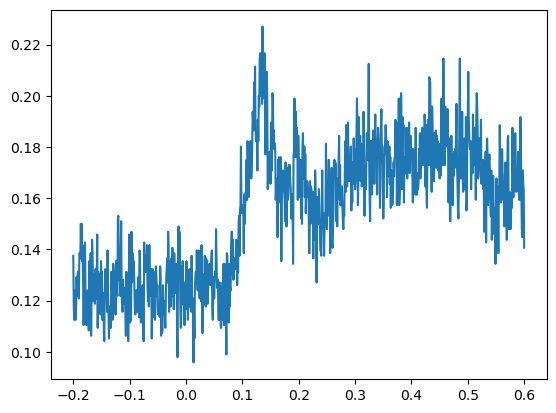

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

def select_conditions(epochs_stacked,column_name,items_to_select):
    if type(items_to_select)==list:
        selected_epochs = epochs_stacked[np.any([epochs_stacked.metadata[column_name] == i  for i in items_to_select],axis=0)]
    if type(items_to_select)==str:
        selected_epochs = epochs_stacked[epochs_stacked.metadata[column_name] == items_to_select]
    return selected_epochs

def train_test_split(epo_stacked,test_run):
    epochs_test=epo_stacked[f'run_nr == {test_run}']
    y_test = epochs_test.metadata['condition'].to_numpy()
    x_test = epochs_test._data

    epochs_train=epo_stacked[f'run_nr != {test_run}']
    y_train = epochs_train.metadata['condition'].to_numpy()
    x_train = epochs_train._data

    return x_train, x_test, y_train, y_test

def run_decoding(x_train,y_train,x_test,y_test):
    pipe = Pipeline([('scaler', StandardScaler()), 
            ('classifier', svm.SVC(kernel='linear',C=1))])
    pipe.fit(x_train,y_train)
    predictions = pipe.predict(x_test)
    accuracy = predictions == y_test

    return np.mean(accuracy)

def run_timeseries_decoding(epochs_selected,test_run):
    x_train, x_test, y_train, y_test = train_test_split(epochs_selected,test_run)
    cv_res = Parallel(n_jobs=48, prefer="threads")(delayed(run_decoding)(x_train[:,:,t],y_train,x_test[:,:,t],y_test) for t in range(len(epochs_selected.times)))
    return cv_res


## WITHIN DECODING: simple timeseries
# THIS IS TOO SLOW
# program_starts = time.time()
# epochs_selected = select_conditions(epochs_stacked,column_name='block_type',items_to_select='Watch_Still')
# res = Parallel(n_jobs=48, prefer="threads")(delayed(run_timeseries_decoding)(select_conditions(epochs_stacked,column_name='block_type',items_to_select='Watch_Still'), test_run) for test_run in np.unique(epochs_selected.metadata.run_nr))
# time_series_results = np.mean(np.array(res),axis=0)
# print("parallel: {0}".format(time.time() - program_starts))


#Write a code with dictionary specifying all condition types I care about 
#Or pandas data file with each condition & accuracies
program_starts = time.time()
accuracy = []
epochs_selected = select_conditions(epochs_stacked,column_name='block_type',items_to_select='Watch_Still')
for test_run in np.unique(epochs_selected.metadata.run_nr):
    x_train, x_test, y_train, y_test = train_test_split(epochs_selected,test_run)
    accuracy.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding)(x_train[:,:,t],y_train,x_test[:,:,t],y_test) for t in range(len(epochs_stacked.times))))
print("loop: {0}".format(time.time() - program_starts))
plt.plot(epochs_stacked.times, np.mean(np.array(accuracy),axis=0))


## WITHIN DECODING: time-generalization
epochs_selected = select_conditions(epochs_stacked,column_name='block_type',items_to_select='Watch_Still')

def run_timegen(epochs_selected,test_run):
    results_matrix = np.zeros((len(epochs_selected.times), len(epochs_selected.times)))
    x_train, x_test, y_train, y_test = train_test_split(epochs_selected,test_run)
    for training_tp in range(len(epochs_selected.times)):
        res = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding)(x_train[:,:,training_tp],y_train,x_test[:,:,t],y_test) for t in range(len(epochs_selected.times)))
        results_matrix[training_tp,:] = res
    return results_matrix

# accuracy = []
# for test_run in np.unique(epochs_selected.metadata.run_nr):
#     accuracy.append(run_timegen(epochs_selected,test_run))
# time_gen_results = np.mean(np.array(accuracy),axis=0)
# plt.plot(time_gen_results)


In [8]:
#Temporal Generalization


epochs_selected = select_conditions(epochs_stacked,column_name='block_type',items_to_select='Watch_Still')

accuracy = []
for test_run in np.unique(epochs_selected.metadata.run_nr):
    print(test_run)
    matrix = run_timegen(epochs_selected, test_run)
    accuracy.append(matrix)

0
1
2
3


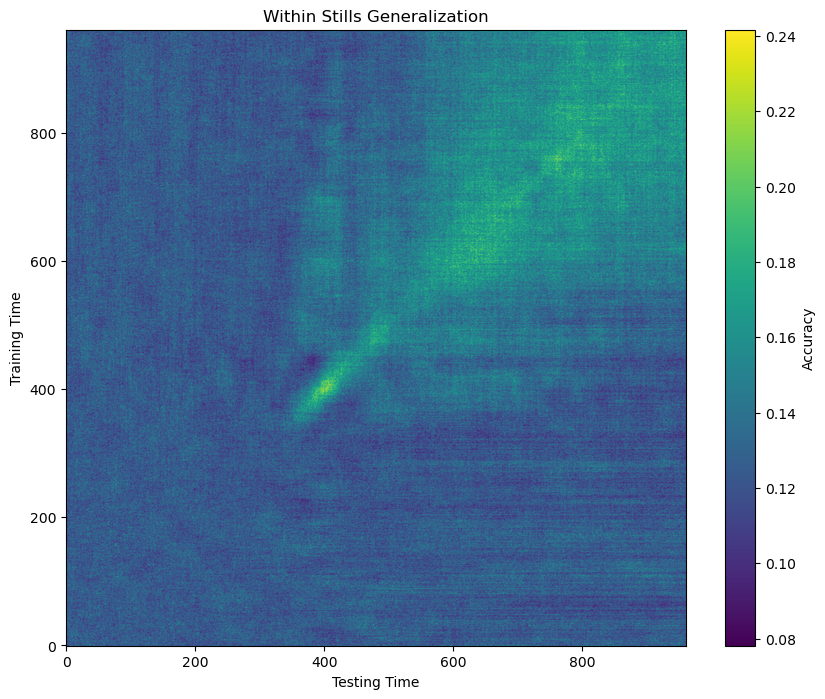

In [9]:
average_array = np.mean(accuracy, axis=0)
plt.figure(figsize=(10, 8))
plt.imshow(average_array, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Accuracy')
plt.xlabel('Testing Time')
plt.ylabel('Training Time')
plt.title('Within Stills Generalization')
plt.show()

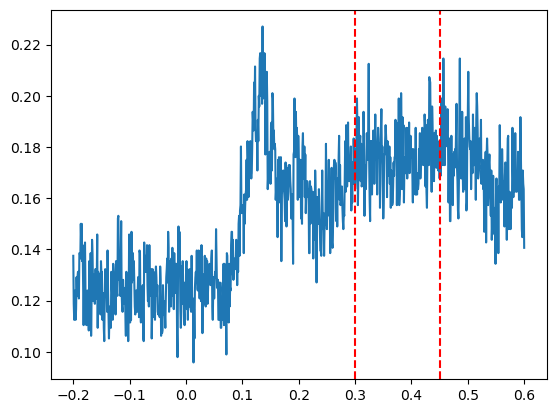

In [85]:
plt.plot(epochs_stacked.times, np.mean(np.array(accuracy),axis=0))
plt.axvline(x=.3, color='red', linestyle='--', label='Time 0.1')
plt.axvline(x=.45, color='red', linestyle='--', label='Time 0.1')

Cross Decoding

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt


#Average across or pick time points and then test for each time point 
specifyTime = True

def select_conditions(epochs_stacked,column_name,items_to_select):
    if type(items_to_select)==list:
        selected_epochs = epochs_stacked[np.any([epochs_stacked.metadata[column_name] == i  for i in items_to_select],axis=0)]
    if type(items_to_select)==str:
        selected_epochs = epochs_stacked[epochs_stacked.metadata[column_name] == items_to_select]
    return selected_epochs

def train_test_split_cross(epo_stacked, epo_stackedMovie, test_condition, start_time, end_time):
    epochs_test=epo_stackedMovie[epo_stackedMovie.metadata['condition'] == test_condition]
    y_test = epochs_test.metadata['condition'].to_numpy()
    x_test = epochs_test._data
    #x_test = x_test[100:500:]
    x_test.shape
    epochs_train=epo_stacked[epo_stacked.metadata['block_type'] == 'Watch_Still']
    y_train = epochs_train.metadata['condition'].to_numpy()
    mask = (epochs_train.times >= start_time) & (epochs_train.times <= end_time)


    if specifyTime == True:
        mask = (epochs_train.times >= start_time) & (epochs_train.times <= end_time)
        x_train = np.mean(epochs_train._data[:,:,mask], axis = 2)

    else:
        x_train = epochs_train._data
    return x_train, x_test, y_train, y_test

def run_decoding_cross(x_train,y_train,x_test):
    pipe = Pipeline([('scaler', StandardScaler()), 
            ('classifier', svm.SVC(kernel='linear',C=1))])
    pipe.fit(x_train,y_train)
    #Step where I average at each sensor weight, would need to loop around fit for each time point
    #And then I would let it return the weight matrix, and apply an average of the weights to the testing data
    predictions = pipe.predict(x_test)
    return predictions

In [10]:
def find_contacting_movies_and_samples(input_number, movies):
    def normalize_frame(frame):
        """Normalize frame to be within 0 to 359."""
        return frame % 360

    def frames_contact(movie_start, input_number):
        """Check if a movie intersects the input number."""
        right_frames = [(movie_start + i) % 360 for i in range(181)]
        left_frames = [(movie_start - i) % 360 for i in range(181)]
        left_frames = [normalize_frame(f) for f in left_frames]

        return input_number in right_frames, input_number in left_frames

    def calculate_sample_time(movie_start, input_number, direction):
        """Calculate the sample time at which the movie passes through the input number."""
        if direction == "Right":
            frame_difference = (input_number - movie_start) % 360
        else:  # direction == "Left"
            frame_difference = (movie_start - input_number) % 360
        
        if frame_difference == 0:
            return 60
        else:
            return 60 + frame_difference * 20

    result = {}
    for movie_start in movies:
        right_contacts, left_contacts = frames_contact(movie_start, input_number)
        
        if right_contacts:
            if movie_start < 100: #Ensure correct naming, movies less than 100 have two zeros in front of them in condition name
                movie_name = f"00{movie_start}_Right"
            else:
                movie_name = f"0{movie_start}_Right"
            sample_time = calculate_sample_time(movie_start, input_number, "Right") + 240
            result[movie_name] = sample_time
        
        if left_contacts:
            if movie_start < 100:
                movie_name = f"00{movie_start}_Left"
            else:
                movie_name = f"0{movie_start}_Left"
            sample_time = calculate_sample_time(movie_start, input_number, "Left") + 240
            result[movie_name] = sample_time

    return result

# Example usage:
input_number = [0, 45, 90, 135, 180, 225, 270, 315]
movies = [22, 67, 122, 157, 202, 247, 292, 337]  # List of starting frames for movies
result_list = []

for i in input_number:
    result_list.append(find_contacting_movies_and_samples(i, movies))


In [11]:
print(result_list)

[{'0022_Left': 740, '0067_Left': 1640, '0122_Left': 2740, '0157_Left': 3440, '0202_Right': 3460, '0247_Right': 2560, '0292_Right': 1660, '0337_Right': 760}, {'0022_Right': 760, '0067_Left': 740, '0122_Left': 1840, '0157_Left': 2540, '0202_Left': 3440, '0247_Right': 3460, '0292_Right': 2560, '0337_Right': 1660}, {'0022_Right': 1660, '0067_Right': 760, '0122_Left': 940, '0157_Left': 1640, '0202_Left': 2540, '0247_Left': 3440, '0292_Right': 3460, '0337_Right': 2560}, {'0022_Right': 2560, '0067_Right': 1660, '0122_Right': 560, '0157_Left': 740, '0202_Left': 1640, '0247_Left': 2540, '0292_Left': 3440, '0337_Right': 3460}, {'0022_Right': 3460, '0067_Right': 2560, '0122_Right': 1460, '0157_Right': 760, '0202_Left': 740, '0247_Left': 1640, '0292_Left': 2540, '0337_Left': 3440}, {'0022_Left': 3440, '0067_Right': 3460, '0122_Right': 2360, '0157_Right': 1660, '0202_Right': 760, '0247_Left': 740, '0292_Left': 1640, '0337_Left': 2540}, {'0022_Left': 2540, '0067_Left': 3440, '0122_Right': 3260, '015

In [12]:
# Create four lists to store the separated dictionaries
list_1 = []
list_2 = []
list_3 = []
list_4 = []

# Process each dictionary in result_list
for original_dict in result_list:
    # Sort the dictionary items by their values (ascending)
    sorted_items = sorted(original_dict.items(), key=lambda item: item[1])
    
    # Create new dictionaries for each list based on the sorted values
    dict_1 = dict(sorted_items[:2])  # Lowest 2 values
    dict_2 = dict(sorted_items[2:4])  # Second lowest 2 values
    dict_3 = dict(sorted_items[4:6])  # Third lowest 2 values
    dict_4 = dict(sorted_items[6:])   # Remaining values
    
    # Append the new dictionaries to the respective lists
    list_1.append(dict_1)
    list_2.append(dict_2)
    list_3.append(dict_3)
    list_4.append(dict_4)

# Print the results for verification
print("List 1:", list_1)
print("List 2:", list_2)
print("List 3:", list_3)
print("List 4:", list_4)

List 1: [{'0022_Left': 740, '0337_Right': 760}, {'0067_Left': 740, '0022_Right': 760}, {'0067_Right': 760, '0122_Left': 940}, {'0122_Right': 560, '0157_Left': 740}, {'0202_Left': 740, '0157_Right': 760}, {'0247_Left': 740, '0202_Right': 760}, {'0292_Left': 740, '0247_Right': 760}, {'0337_Left': 740, '0292_Right': 760}]
List 2: [{'0067_Left': 1640, '0292_Right': 1660}, {'0337_Right': 1660, '0122_Left': 1840}, {'0157_Left': 1640, '0022_Right': 1660}, {'0202_Left': 1640, '0067_Right': 1660}, {'0122_Right': 1460, '0247_Left': 1640}, {'0292_Left': 1640, '0157_Right': 1660}, {'0337_Left': 1640, '0202_Right': 1660}, {'0022_Left': 1640, '0247_Right': 1660}]
List 3: [{'0247_Right': 2560, '0122_Left': 2740}, {'0157_Left': 2540, '0292_Right': 2560}, {'0202_Left': 2540, '0337_Right': 2560}, {'0247_Left': 2540, '0022_Right': 2560}, {'0292_Left': 2540, '0067_Right': 2560}, {'0122_Right': 2360, '0337_Left': 2540}, {'0022_Left': 2540, '0157_Right': 2560}, {'0067_Left': 2540, '0202_Right': 2560}]
List 

In [14]:
for i in list_1:
    print(i)
    for movie, sample_time in i.items():
        x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, .2, .3)

{'0022_Left': 740, '0337_Right': 760}
{'0067_Left': 740, '0022_Right': 760}
{'0067_Right': 760, '0122_Left': 940}
{'0122_Right': 560, '0157_Left': 740}
{'0202_Left': 740, '0157_Right': 760}
{'0247_Left': 740, '0202_Right': 760}
{'0292_Left': 740, '0247_Right': 760}
{'0337_Left': 740, '0292_Right': 760}


In [15]:
print(x_train)

[[ 1.48402113e-13  1.61148338e-13  1.48691157e-13 ... -1.17342584e-13
  -6.09996643e-14 -1.86664081e-13]
 [-6.56171081e-15 -1.61238535e-14  2.03311511e-14 ... -6.73767864e-14
  -1.65788328e-13 -7.68039929e-14]
 [-1.28020672e-13 -1.43316778e-13 -1.59440526e-13 ... -7.01727837e-14
  -7.95530135e-14 -9.79666025e-14]
 ...
 [-7.64146182e-14 -7.89615022e-14 -9.03521568e-14 ... -1.19512156e-13
  -3.79192000e-14 -1.48463981e-13]
 [-4.84143408e-14  7.80722886e-15  1.90619078e-14 ... -1.72335323e-13
  -1.46452360e-13  9.32375052e-14]
 [ 4.94890364e-14  1.16568756e-14  2.08787347e-15 ... -1.27623261e-13
  -7.31782915e-14 -6.03909627e-14]]


In [23]:
print(y_test)

['0292_Right' '0292_Right' '0292_Right' '0292_Right' '0292_Right'
 '0292_Right' '0292_Right' '0292_Right' '0292_Right' '0292_Right'
 '0292_Right' '0292_Right' '0292_Right' '0292_Right' '0292_Right'
 '0292_Right' '0292_Right' '0292_Right' '0292_Right' '0292_Right'
 '0292_Right']


In [30]:
decoding_dictList1 = []
for i in list_1:
    decoding_dict = {}

    for movie, sample_time in i.items():
        x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, .3, .45)

        startTime = sample_time - 700
        endTime = sample_time + 2900
        #decoding_list.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times[startTime:endTime]))))
        decoding_list = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train[:640],y_train[:640],x_test[:,:,t]) for t in range(startTime, endTime))
        movie = movie
        decoding_dict[movie] = decoding_list
        print('movie is', movie)
        print('epo time is', startTime, endTime)
    decoding_dictList1.append(decoding_dict)

movie is 0022_Left
epo time is 40 3640
movie is 0337_Right
epo time is 60 3660
movie is 0067_Left
epo time is 40 3640
movie is 0022_Right
epo time is 60 3660
movie is 0067_Right
epo time is 60 3660
movie is 0122_Left
epo time is 240 3840
movie is 0122_Right
epo time is -140 3460
movie is 0157_Left
epo time is 40 3640
movie is 0202_Left
epo time is 40 3640
movie is 0157_Right
epo time is 60 3660
movie is 0247_Left
epo time is 40 3640
movie is 0202_Right
epo time is 60 3660
movie is 0292_Left
epo time is 40 3640
movie is 0247_Right
epo time is 60 3660
movie is 0337_Left
epo time is 40 3640
movie is 0292_Right
epo time is 60 3660


In [51]:
decoding_dictList = []
decoding_dictList2 = []
decoding_dictList3 = []
decoding_dictList4 = []
decoding_dictList5 = []
decoding_dictList6 = []


for i in list_1:
    decoding_dict = {}

    for movie, sample_time in i.items():
        x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, .3, .45)

        startTime = sample_time - 700
        endTime = sample_time + 2900
        #decoding_list.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times[startTime:endTime]))))
        decoding_list = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train[:640],y_train[:640],x_test[:,:,t]) for t in range(startTime, endTime))
        movie = movie
        decoding_dict[movie] = decoding_list
        print('movie is', movie)
        print('epo time is', startTime, endTime)
    decoding_dictList.append(decoding_dict)

for i in list_1:
    decoding_dict = {}

    for movie, sample_time in i.items():
        x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, .11, .16)

        startTime = sample_time - 700
        endTime = sample_time + 2900
        #decoding_list.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times[startTime:endTime]))))
        decoding_list = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train[:640],y_train[:640],x_test[:,:,t]) for t in range(startTime, endTime))
        movie = movie
        decoding_dict[movie] = decoding_list
        print('movie is', movie)
        print('epo time is', startTime, endTime)
    decoding_dictList2.append(decoding_dict)

for i in list_2:
    decoding_dict = {}

    for movie, sample_time in i.items():
        x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, .11, .16)

        startTime = sample_time - 1000
        endTime = sample_time + 1000
        #decoding_list.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times[startTime:endTime]))))
        decoding_list = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train[:640],y_train[:640],x_test[:,:,t]) for t in range(startTime, endTime))
        movie = movie
        decoding_dict[movie] = decoding_list
        print('movie is', movie)
        print('epo time is', startTime, endTime)
    decoding_dictList3.append(decoding_dict)

for i in list_3:
    decoding_dict = {}

    for movie, sample_time in i.items():
        x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, .3, .45)

        startTime = sample_time - 1000
        endTime = sample_time + 1000
        #decoding_list.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times[startTime:endTime]))))
        decoding_list = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train[:640],y_train[:640],x_test[:,:,t]) for t in range(startTime, endTime))
        movie = movie
        decoding_dict[movie] = decoding_list
        print('movie is', movie)
        print('epo time is', startTime, endTime)
    decoding_dictList4.append(decoding_dict)

for i in result_list:
    decoding_dict = {}

    for movie, sample_time in i.items():
        x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, .3, .45)

        startTime = sample_time - 400
        endTime = sample_time + 400
        #decoding_list.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times[startTime:endTime]))))
        decoding_list = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train[:640],y_train[:640],x_test[:,:,t]) for t in range(startTime, endTime))
        movie = movie
        decoding_dict[movie] = decoding_list
        print('movie is', movie)
        print('epo time is', startTime, endTime)
    decoding_dictList5.append(decoding_dict)

for i in result_list:
    decoding_dict = {}

    for movie, sample_time in i.items():
        x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, .11, .16)

        startTime = sample_time - 400
        endTime = sample_time + 400
        #decoding_list.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times[startTime:endTime]))))
        decoding_list = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train[:640],y_train[:640],x_test[:,:,t]) for t in range(startTime, endTime))
        movie = movie
        decoding_dict[movie] = decoding_list
        print('movie is', movie)
        print('epo time is', startTime, endTime)
    decoding_dictList6.append(decoding_dict)


movie is 0022_Left
epo time is 40 3640
movie is 0337_Right
epo time is 60 3660
movie is 0067_Left
epo time is 40 3640
movie is 0022_Right
epo time is 60 3660
movie is 0067_Right
epo time is 60 3660
movie is 0122_Left
epo time is 240 3840
movie is 0122_Right
epo time is -140 3460
movie is 0157_Left
epo time is 40 3640
movie is 0202_Left
epo time is 40 3640
movie is 0157_Right
epo time is 60 3660
movie is 0247_Left
epo time is 40 3640
movie is 0202_Right
epo time is 60 3660
movie is 0292_Left
epo time is 40 3640
movie is 0247_Right
epo time is 60 3660
movie is 0337_Left
epo time is 40 3640
movie is 0292_Right
epo time is 60 3660
movie is 0022_Left
epo time is 40 3640
movie is 0337_Right
epo time is 60 3660
movie is 0067_Left
epo time is 40 3640
movie is 0022_Right
epo time is 60 3660
movie is 0067_Right
epo time is 60 3660
movie is 0122_Left
epo time is 240 3840
movie is 0122_Right
epo time is -140 3460
movie is 0157_Left
epo time is 40 3640
movie is 0202_Left
epo time is 40 3640
movie i

In [31]:
#This function remaps the labels inside of decoding dictionaries to make them relative to a target, so that it can be averaged across cross-decoding results
#Wherein the target condition differs and the stills that appeared before and after it differ
def circularDict(correctCond, direction):
    #We know that in circular space this is the order of arrangement for conditions
    circularSpace = ['Back', '135_Left', 'Left', '45_Left', 'Center', '45_Right', 'Right', '135_Right']
    #Find where in the circular space the target condition is located
    index = circularSpace.index(correctCond)
    #create a new dictionary that will 
    new_dict = {}
    for i in range(len(circularSpace)):
        new_index = (index + i) % len(circularSpace)
        #If the movie is moving in opposite directions, what is before and after a target condition flips
        if direction == 'Left':
            label1 = 'after'
            label2 = 'before'
        else:
            label1 = 'before'
            label2 = 'after'
        distance = i
        if distance == 0:
            new_dict[circularSpace[new_index]] = 'target_cond'
        elif distance == 4:
            new_dict[circularSpace[new_index]] = 'opposite'
        elif distance < 4:
            new_dict[circularSpace[new_index]] = f'{distance}_{label2}'
        else:
            before_index = (index - (len(circularSpace) - i)) % len(circularSpace)
            if (len(circularSpace) - i) == 4:
                new_dict[circularSpace[before_index]] = 'opposite'
            else:
                new_dict[circularSpace[before_index]] = f'{len(circularSpace) - i}_{label1}'

    return new_dict

def remap_array(i, relabel_dict):
    return [relabel_dict.get(element, element) for element in i]

def relabelCond(decoding_list, relabel_dict):
    new_list = []
    for i in decoding_list:
        new_array = remap_array(i, relabel_dict)
        new_list.append(new_array)
    return new_list

ordered_conditions = ['Center', '45_Right', 'Right', '135_Right', 'Back', '135_Left', 'Left', '45_Left']

In [32]:
decoding_dictList = decoding_dictList1

In [34]:
standardized_dictList = []
for index, condition in enumerate(ordered_conditions):
    decoding_dict = decoding_dictList[index]
    print(condition)
    standardized_dict = {}
    for movie, decoding_list in decoding_dict.items():
        print(movie)
        underscore_pos = movie.find('_')
        direction = movie[underscore_pos + 1:]
        remap_dict = circularDict(condition, direction)
        print(remap_dict)
        new_list = relabelCond(decoding_list, remap_dict)
        standardized_dict[movie] = new_list
    standardized_dictList.append(standardized_dict)

Center
0022_Left
{'Center': 'target_cond', '45_Right': '1_before', 'Right': '2_before', '135_Right': '3_before', 'Back': 'opposite', '135_Left': '3_after', 'Left': '2_after', '45_Left': '1_after'}
0337_Right
{'Center': 'target_cond', '45_Right': '1_after', 'Right': '2_after', '135_Right': '3_after', 'Back': 'opposite', '135_Left': '3_before', 'Left': '2_before', '45_Left': '1_before'}
45_Right
0067_Left
{'45_Right': 'target_cond', 'Right': '1_before', '135_Right': '2_before', 'Back': '3_before', '135_Left': 'opposite', 'Left': '3_after', '45_Left': '2_after', 'Center': '1_after'}
0022_Right
{'45_Right': 'target_cond', 'Right': '1_after', '135_Right': '2_after', 'Back': '3_after', '135_Left': 'opposite', 'Left': '3_before', '45_Left': '2_before', 'Center': '1_before'}
Right
0067_Right
{'Right': 'target_cond', '135_Right': '1_after', 'Back': '2_after', '135_Left': '3_after', 'Left': 'opposite', '45_Left': '3_before', 'Center': '2_before', '45_Right': '1_before'}
0122_Left
{'Right': 'targ

In [42]:
print(decoding_dictList[0])

{'0022_Left': [array(['135_Left', 'Center', '45_Right', 'Center', 'Back', 'Center',
       '45_Right', '135_Left', '135_Left', '135_Right', '135_Left',
       'Left', 'Left', '135_Left', '45_Left', 'Right', 'Center',
       '45_Left', 'Back', 'Center', 'Right'], dtype=object), array(['Center', 'Left', 'Back', '135_Right', 'Center', 'Center',
       '45_Right', '135_Left', '135_Left', 'Center', 'Left', '45_Right',
       '45_Right', '135_Left', '45_Left', 'Right', 'Left', '45_Left',
       '135_Right', 'Center', '45_Right'], dtype=object), array(['Center', 'Left', 'Center', '45_Left', 'Center', 'Left',
       '135_Left', '135_Left', 'Center', 'Back', '45_Right', 'Back',
       '45_Right', '135_Left', 'Left', 'Right', '135_Left', '45_Left',
       'Right', '135_Right', '45_Right'], dtype=object), array(['45_Right', '135_Right', 'Right', '45_Left', 'Center', '135_Left',
       '45_Right', 'Center', 'Back', 'Back', 'Right', 'Back', 'Right',
       '135_Left', 'Left', 'Right', 'Left', '135_

In [43]:
print(standardized_dictList[0]['0022_Left'])

[['3_after', 'target_cond', '1_before', 'target_cond', 'opposite', 'target_cond', '1_before', '3_after', '3_after', '3_before', '3_after', '2_after', '2_after', '3_after', '1_after', '2_before', 'target_cond', '1_after', 'opposite', 'target_cond', '2_before'], ['target_cond', '2_after', 'opposite', '3_before', 'target_cond', 'target_cond', '1_before', '3_after', '3_after', 'target_cond', '2_after', '1_before', '1_before', '3_after', '1_after', '2_before', '2_after', '1_after', '3_before', 'target_cond', '1_before'], ['target_cond', '2_after', 'target_cond', '1_after', 'target_cond', '2_after', '3_after', '3_after', 'target_cond', 'opposite', '1_before', 'opposite', '1_before', '3_after', '2_after', '2_before', '3_after', '1_after', '2_before', '3_before', '1_before'], ['1_before', '3_before', '2_before', '1_after', 'target_cond', '3_after', '1_before', 'target_cond', 'opposite', 'opposite', '2_before', 'opposite', '2_before', '3_after', '2_after', '2_before', '2_after', '3_after', '2_a

In [35]:
from collections import defaultdict
average_proportionsList = []
for i in standardized_dictList:
    # Assuming predictions_dict is your dictionary where keys are items and values are lists of predictions
    # Initialize dictionaries to store counts and totals
    time_point_counts = defaultdict(lambda: defaultdict(int))
    time_point_totals = defaultdict(int)

    # Iterate through each item in the dictionary
    for item in i.values():
        # Iterate through each time point in the item
        for time_point, predictions_at_time in enumerate(item):
            # Count predictions at each time point
            for prediction in predictions_at_time:
                time_point_counts[time_point][prediction] += 1
                time_point_totals[time_point] += 1

    # Initialize dictionary to store average proportions
    average_proportions = defaultdict(dict)

    # Calculate proportions and average across all items
    for time_point in time_point_counts:
        for prediction, count in time_point_counts[time_point].items():
            proportion = count / time_point_totals[time_point]
            average_proportions[time_point][prediction] = proportion
    average_proportionsList.append(average_proportions)

    # Now average_proportions contains the average proportion of each prediction at each time point


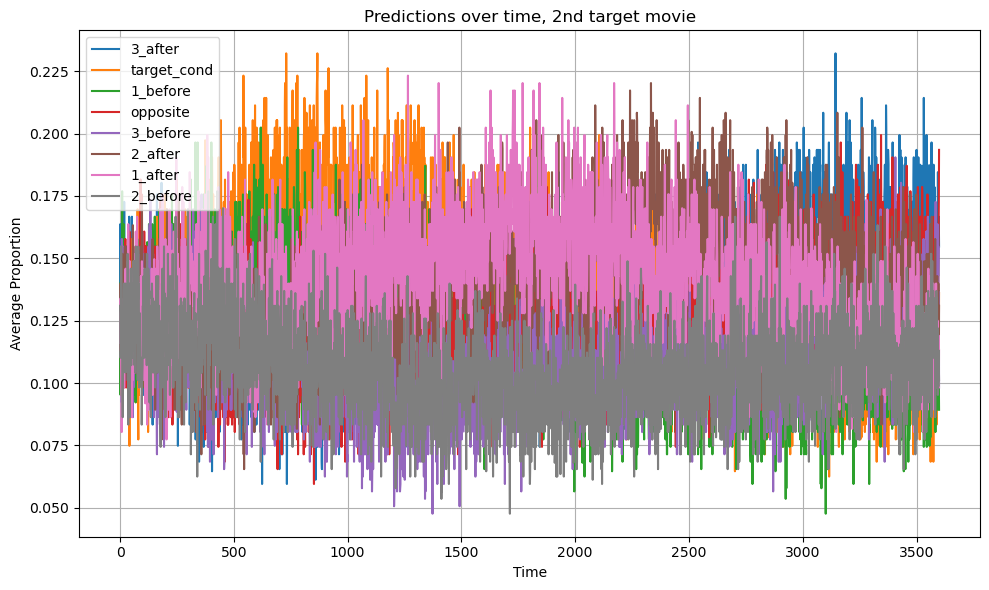

In [36]:
average_proportions_list = [average_proportionsList[0], average_proportionsList[1], average_proportionsList[2], average_proportionsList[3], average_proportionsList[4], average_proportionsList[5],
                            average_proportionsList[6], average_proportionsList[7]]


combined_proportions = defaultdict(lambda: defaultdict(list))

for average_proportions in average_proportions_list:
    for time_point, predictions in average_proportions.items():
        for prediction, proportion in predictions.items():
            combined_proportions[time_point][prediction].append(proportion)

# Calculate overall average proportions
overall_average_proportions = defaultdict(dict)

for time_point, predictions in combined_proportions.items():
    for prediction, proportions in predictions.items():
        average_proportion = sum(proportions) / len(proportions)
        overall_average_proportions[time_point][prediction] = average_proportion

# Extract predictions and time points
time_points = sorted(overall_average_proportions.keys())
predictions = list(next(iter(overall_average_proportions.values())).keys())



# Plotting each prediction as a separate line
plt.figure(figsize=(10, 6))


for prediction in predictions:
    proportions = [overall_average_proportions[time_point][prediction] for time_point in time_points]
    plt.plot(time_points, proportions, label=prediction)




plt.xlabel('Time')
plt.ylabel('Average Proportion')
plt.title('Predictions over time, 2nd target movie')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
#Shifting time window of training times

trainStart = -0.2
increment = .01
trainEnd = trainStart + .04
print(trainEnd)
masterList = []
while trainEnd < .6:
    print('yes')
    decoding_dictList = []
    for i in result_list:
        decoding_dict = {}

        for movie, sample_time in i.items():
            x_train, x_test, y_train, y_test = train_test_split_cross(epochs_stacked, epochs_stackedMovie, movie, trainStart, trainEnd)

            startTime = sample_time - 10
            endTime = sample_time + 10
            #decoding_list.append(Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(len(epochs_stackedMovie.times[startTime:endTime]))))
            decoding_list = Parallel(n_jobs=12, prefer="threads")(delayed(run_decoding_cross)(x_train,y_train,x_test[:,:,t]) for t in range(startTime, endTime))
            movie = movie
            decoding_dict[movie] = decoding_list
            print('movie is', movie)
            print('epo time is', startTime, endTime)
        decoding_dictList.append(decoding_dict)
    masterList.append(decoding_dictList)
    trainStart += increment
    trainEnd += increment


-0.16
yes
movie is 0022_Left
epo time is 730 750
movie is 0067_Left
epo time is 1630 1650
movie is 0122_Left
epo time is 2730 2750
movie is 0157_Left
epo time is 3430 3450
movie is 0202_Right
epo time is 3450 3470
movie is 0247_Right
epo time is 2550 2570
movie is 0292_Right
epo time is 1650 1670
movie is 0337_Right
epo time is 750 770
movie is 0022_Right
epo time is 750 770
movie is 0067_Left
epo time is 730 750
movie is 0122_Left
epo time is 1830 1850
movie is 0157_Left
epo time is 2530 2550
movie is 0202_Left
epo time is 3430 3450
movie is 0247_Right
epo time is 3450 3470
movie is 0292_Right
epo time is 2550 2570
movie is 0337_Right
epo time is 1650 1670
movie is 0022_Right
epo time is 1650 1670
movie is 0067_Right
epo time is 750 770
movie is 0122_Left
epo time is 930 950
movie is 0157_Left
epo time is 1630 1650
movie is 0202_Left
epo time is 2530 2550
movie is 0247_Left
epo time is 3430 3450
movie is 0292_Right
epo time is 3450 3470
movie is 0337_Right
epo time is 2550 2570
movie 

In [15]:

#Function takes in a a list of decoding dictionaries, each dictionary maps a particular movie condition to a set of predictions over time
#Here we are collapsing across time and asking how many times a given still condition is predicted relative to all other predictions
#It is assumed that the order of the list matches the order of ordered_conditions, so for instance the first set of dictionaries in the list
#should contain movies where 'center' is the target prediciton, and so we look at the proportion of times 'center' was predicted relative
#to all other predictions
ordered_conditions = ['Center', '45_Right', 'Right', '135_Right', 'Back', '135_Left', 'Left', '45_Left']
def getAveragePrediction(decoding_dictList, ordered_conditions):
    proportionList = []
    for index, cond in enumerate(ordered_conditions):
        all_strings = [item for sublist in decoding_dictList[index].values() for item in sublist]
        flattened_list = [item for array in all_strings for item in array]
        center_count = flattened_list.count(cond)
        total_entries = len(flattened_list)
        proportion = center_count / total_entries
        proportionList.append(proportion)
    values_array = np.array(proportionList)
    return np.mean(values_array)


In [16]:
decoding_peak = []
for i in masterList:
    decoding_peak.append(getAveragePrediction(i, ordered_conditions))

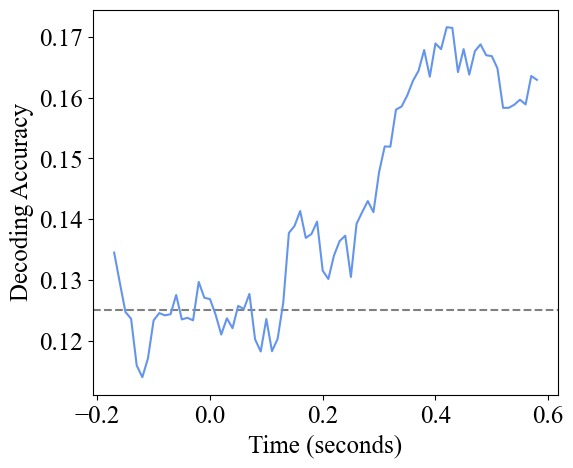

In [40]:
# Generate the time values
start_time = -.17
time_increment = .01
time_values = [start_time + i * time_increment for i in range(len(masterList))]
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'Times New Roman'
# Create the plot
plt.figure(figsize=(6, 5))
plt.axhline(y=.125, color='grey', linestyle='--', label='chance')
plt.plot(time_values, decoding_peak, color = '#6495ED')

# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Decoding Accuracy')


# Display the plot
plt.show()